<h1> Toy examples </h1>

First we load some things. 

In [6]:
import numpy as np
from multiprocessing import Pool
from matplotlib import rcParams
import pickle
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.colors as clr
import scipy.stats
from scipy.integrate import quad
import math
from decimal import *
getcontext().prec = 28
import matplotlib.cm as cm


rcParams.update({'figure.autolayout': True})
plt.rcParams['savefig.dpi'] = 75
plt.rcParams['figure.autolayout'] = False
plt.rcParams['figure.figsize'] = 10, 6
plt.rcParams['axes.labelsize'] = 35
plt.rcParams['axes.titlesize'] = 35
plt.rcParams['font.size'] = 35
plt.rcParams['lines.linewidth'] = 2.0
plt.rcParams['lines.markersize'] = 8
plt.rcParams['legend.fontsize'] = 26
plt.rcParams['text.usetex'] = True
plt.rcParams['font.family'] = "serif"
plt.rcParams['font.serif'] = "cm"
plt.rcParams['text.latex.preamble'] = "\\usepackage{subdepth}"




<h2> 1D examples: </h2> 

We consider three different 1D distributions. A weibull distribution, a checkerboard grid and a normal distribution. I defined classes for each distribution we consider. 

In [7]:

class weibull(): #a weibull distribution with scale set to 1
    
    def __init__(self, a, b):
        self.a = a
        self.b = b
        
    def shape_given_x(self, x):
        return(self.a + self.b * x)
    
    def surv_given_x(self, t, x):
        shape = self.shape_given_x(x)
        return(np.exp(-t ** shape) )
    
    def sample(self, n):
        x = np.random.uniform(0, 1, size = n)
        t = np.zeros(n)
        for i in range(n):
            t[i] = np.random.weibull(a = self.shape_given_x(x[i]) )
        return(x, t)
        

class checkerboard_grid():
    
    def __init__(self, grid_width, grid_length, num_tiles_width, num_tiles_length): #num_tiles_length needs to be even.
        self.grid_width = grid_width
        self.grid_length = grid_length
        self.num_tiles_width = num_tiles_width
        self.num_tiles_length = num_tiles_length
        self.tile_width = self.grid_width / self.num_tiles_width
        self.tile_length = self.grid_length / self.num_tiles_length
        
    def find_class(self, x):
        return(math.floor(x / self.tile_width) % 2)
    
    def surv_given_x(self, t, x):
        c = math.floor(t / (self.tile_length * 2) )
        res = t % (2 * self.tile_length)
        if self.find_class(x) == 0:
            c+= min(1, res / self.tile_length)
        elif self.find_class(x) == 1:
            c+=max(0, (res - self.tile_length) / self.tile_length)
        return( 1 - max(0, min(c / (self.num_tiles_length / 2) , 1) ))
    
    def sample(self, n):
        x = np.random.uniform(0, self.grid_width, size = n)
        t = np.array([self.find_class(xi) for xi in x]) * self.tile_length 
        t += np.random.choice(np.arange(0, self.num_tiles_length, step = 2), size = n) * self.tile_length
        t += np.random.uniform(low = 0, high = self.tile_length, size = n)
        return(x, t)
        
    
class varying_normals():
    
    def __init__(self, mean, var_slope):
        self.mean = mean
        self.var_slope = var_slope
    
    def surv_given_x(self, t, x):
        return(1 - scipy.stats.norm.cdf(t, loc = self.mean, scale = 5 + self.var_slope * x))
    
    def sample(self, n):
        x = np.random.uniform(size = n)
        t = np.zeros(shape = n)
        for i in range(n):
            t[i] = np.random.normal(loc = self.mean, scale = 5 + self.var_slope * x[i])
        return(x, t)
    
        
    
     

<h3> Try out Weibull distribution </h3>

The Weibull has a parameter called the shape of the distribution. To make sure the distribution depends on the covariate $X$ we set shape to be a function of $X$. In particular set $shape=a+bX$, where below we $a = 2$ and $b = 6$. We plot the survival curve for three different $X$ values, and we show a scatterplot of a sample.

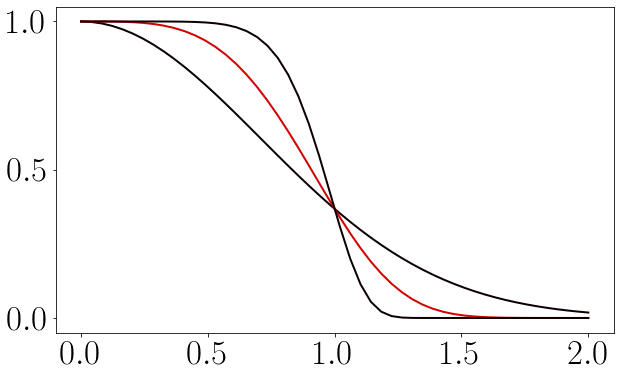

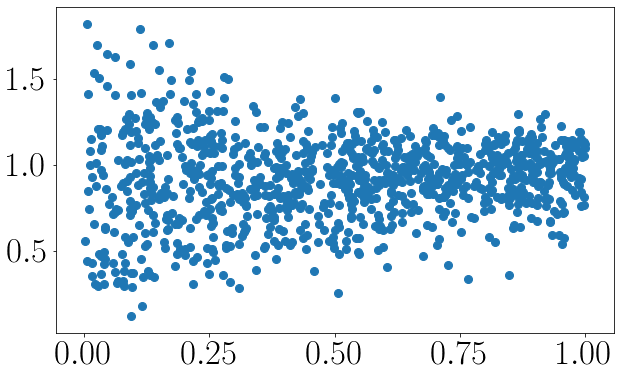

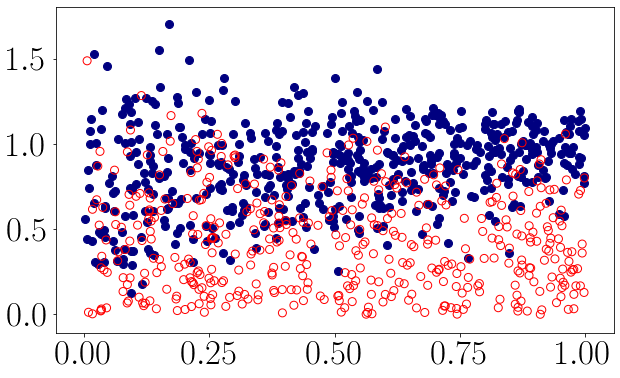

In [8]:
d = weibull(a = 2, b = 6)

t_array = np.linspace(0, 2, num = 50)
x_array = [0, 0.3 , 1]

for x in x_array:
    S = lambda t : d.surv_given_x(t, x)
    plt.plot(t_array, S(t_array), color = cm.hot(x))
plt.savefig("weibull.png", bbox_inches='tight')

plt.show()

n=1000
x,t = d.sample(n)
plt.scatter(x,t)
plt.show()

c = np.random.exponential(1.5, size = n)
d = np.int64(c > t)
z = np.minimum(t, c)

censored, observed = np.where(d==0), np.where(d==1)
l1=plt.scatter(x[observed],z[observed],c='navy',label='observed')
l2=plt.scatter(x[censored],z[censored],facecolors='none', edgecolors='r',label='censored')
plt.show()

<h3> Try out checkerboard </h3>

You can specify the grid_width and grid_lenght, but probably just leave at 1. Then you can specify the number of tiles. But num_tiles_length should be an even integer. 

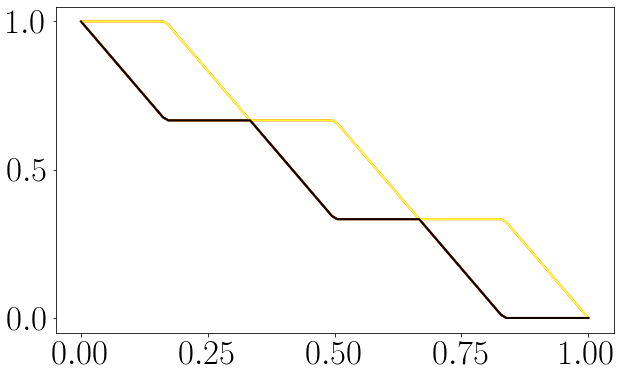

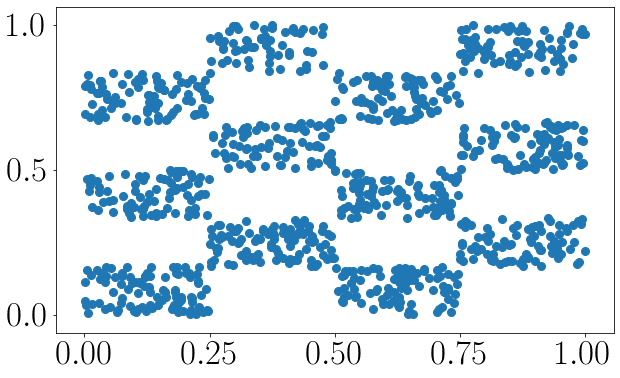

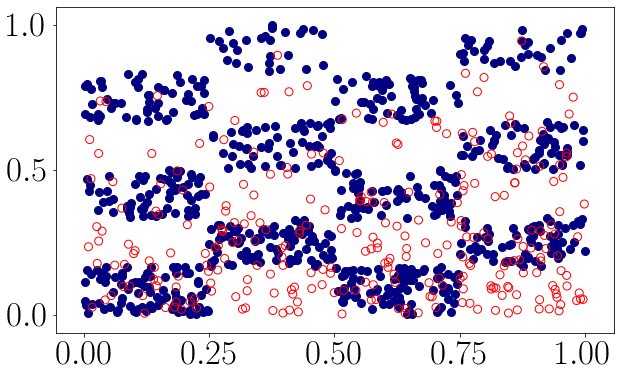

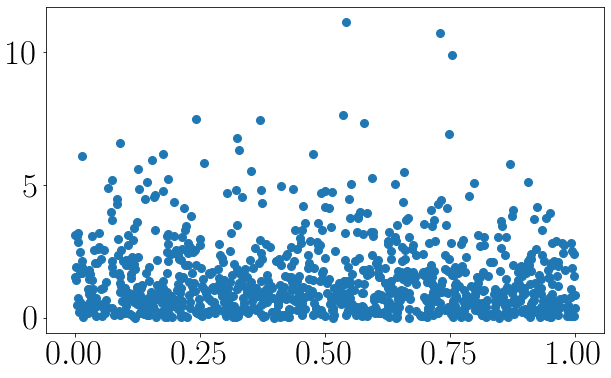

In [9]:
n=1000
d = checkerboard_grid(grid_width = 1, grid_length = 1, num_tiles_width = 4, num_tiles_length = 6)

t_array = np.linspace(0, 1, num = 100)
x_array = [0.1, 0.2, 0.4, 0.6, 0.8, 1]

for x in x_array:
    S = lambda t : d.surv_given_x(t, x)
    S_array = [ S(t) for t in t_array ]    
    plt.plot(t_array, S_array, color = cm.hot(x))
plt.savefig("checkboard.png", bbox_inches='tight')

plt.show()

x,t = d.sample(1000)
plt.scatter(x,t)
plt.show()

c = np.random.exponential(1.5, size = n)
d = np.int64(c > t)
z = np.minimum(t, c)

censored, observed = np.where(d==0), np.where(d==1)
l1=plt.scatter(x[observed],z[observed],c='navy',label='observed')
l2=plt.scatter(x[censored],z[censored],facecolors='none', edgecolors='r',label='censored')
plt.show()

l3=plt.scatter(x,c)
plt.show()

<h3> Trying varying bandwidths </h3>

Here we have a family of normals with fixed mean (below $mean=100$) and variance set to $1+var\_slope\times X$ (below $variance =  1+ 6 X$).

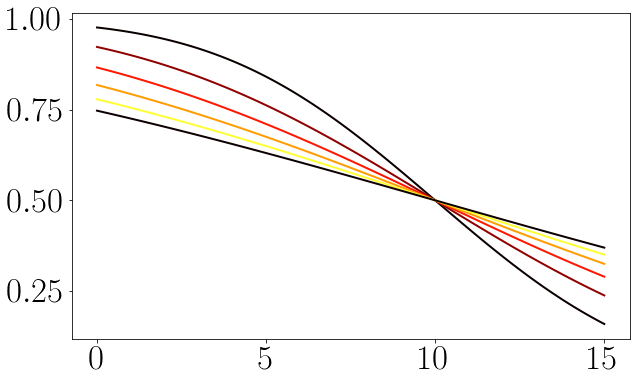

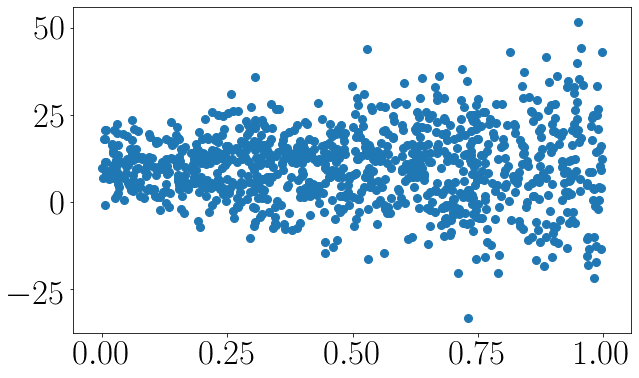

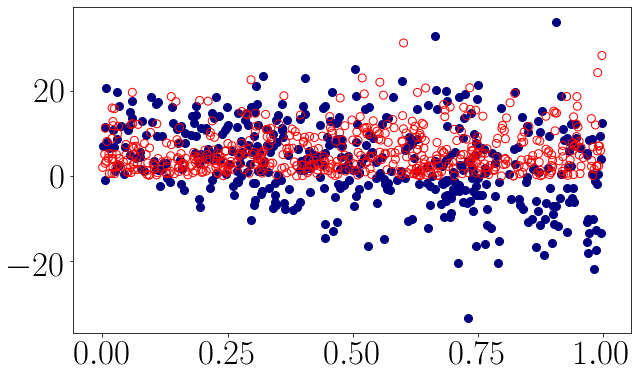

In [51]:
d = varying_normals(mean = 10, var_slope = 10.0)

t_array = np.linspace(0, 15, num = 100)
x_array = [0.0, 0.2, 0.4, 0.6, 0.8, 1]

for x in x_array:
    S = lambda t : d.surv_given_x(t, x)
    S_array = [ S(t) for t in t_array ]    
    plt.plot(t_array, S_array, color = cm.hot(x))
plt.savefig("normals.png", bbox_inches='tight')

plt.show()

x,t = d.sample(1000)
plt.scatter(x,t)
plt.show()

c = np.random.exponential(10, size = n)
d = np.int64(c > t)
z = np.minimum(t, c)

censored, observed = np.where(d==0), np.where(d==1)
l1=plt.scatter(x[observed],z[observed],c='navy',label='observed')
l2=plt.scatter(x[censored],z[censored],facecolors='none', edgecolors='r',label='censored')
plt.show()
